# Imports and Constant

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
HALFDATASETSIZE = 300
EPOCHS = 10
LEARNING_RATE = 0.01
BATCH_SIZE = 32
MOMENTUM = 0.9

# Data recovery

Connexion to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [ ]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
#import zipfile
#for file in os.listdir():
    #if file.endswith(".zip"):
       #with zipfile.ZipFile(file, "r") as zip_file:
            #zip_file.extractall()
        #os.remove(file)

Data Access

In [ ]:
folder_path = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')] #pictures names
print("number of pictures in the file :", len(image_files))

sizes = []
k = 0
for file_name in image_files:
    k += 1
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)

    sizes.append(image.shape)

    if k == 10 :
      break

print(sizes)


nombre d'images dans le dossier : 3875
[(688, 1144, 3), (768, 1112, 3), (1184, 1424, 3), (1080, 1336, 3), (744, 936, 3), (1200, 1560, 3), (1287, 1870, 3), (1000, 1432, 3), (1071, 1264, 3), (568, 888, 3)]


Example on one picture:

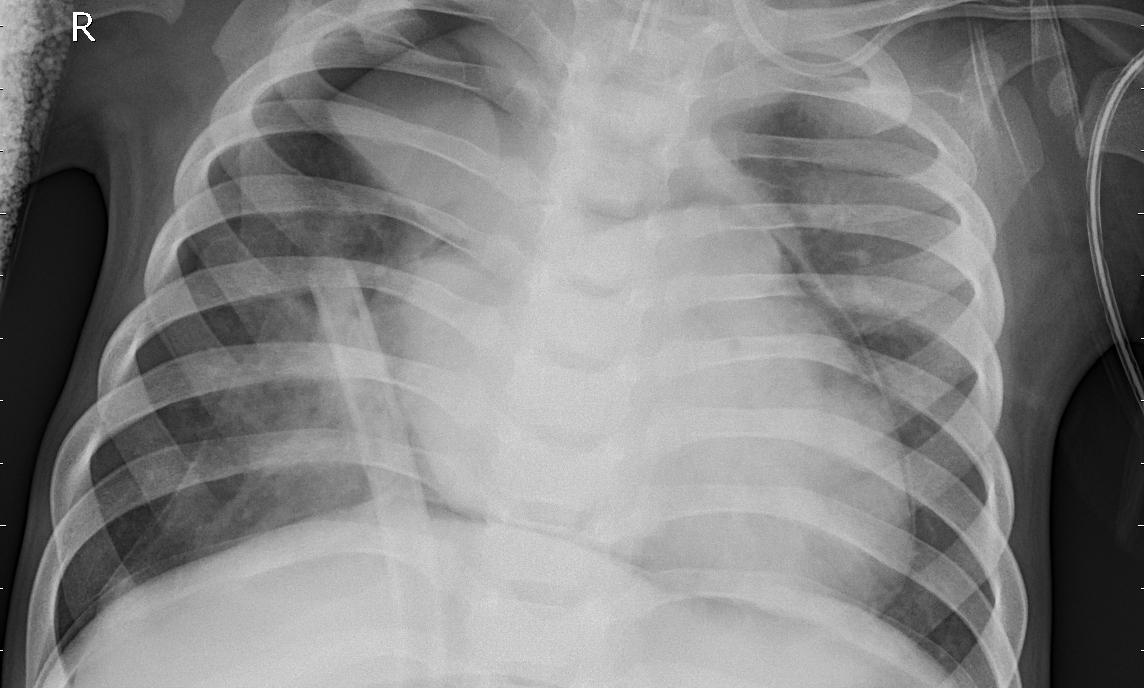

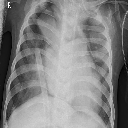

In [ ]:
filename = image_files[0]
file_path = os.path.join(folder_path, filename)
image = cv2.imread(file_path)
cv2_imshow(image)
resized_image = cv2.resize(image, (128, 128))
cv2_imshow(resized_image)

In [ ]:
r = np.array(image[:,:,0])
g = np.array(image[:,:,1])
b = np.array(image[:,:,2])

print(r[:10,:10])
print(g[:10,:10])
print(b[:10,:10])

NameError: ignored

# Balancing of the dataset

In [ ]:
folder_path_train_P = '/content/drive/My Drive/chest_xray/train/PNEUMONIA'
folder_path_train_N = '/content/drive/My Drive/chest_xray/train/NORMAL'
folder_path_test_P = '/content/drive/My Drive/chest_xray/test/PNEUMONIA'
folder_path_test_N = '/content/drive/My Drive/chest_xray/test/NORMAL'

image_files_train_P = [f for f in os.listdir(folder_path_train_P) if f.endswith('.jpeg')]
image_files_train_N = [f for f in os.listdir(folder_path_train_N) if f.endswith('.jpeg')]
image_files_test_P = [f for f in os.listdir(folder_path_test_P) if f.endswith('.jpeg')]
image_files_test_N = [f for f in os.listdir(folder_path_test_N) if f.endswith('.jpeg')]

print("nombre d'images train P :", len(image_files_train_P))
print("nombre d'images train N :", len(image_files_train_N))
print("nombre d'images test P :", len(image_files_test_P))
print("nombre d'images test N :", len(image_files_test_N))

nombre d'images train P : 3875
nombre d'images train N : 1341
nombre d'images test P : 390
nombre d'images test N : 234


In [ ]:
image_files_train_P = image_files_train_P[:HALFDATASETSIZE]
image_files_train_N = image_files_train_N[:HALFDATASETSIZE]

# Balancing of the test

In [ ]:
if False :
  image_files_test_P = image_files_test_P[:234]

  print("nombre d'images test P :", len(image_files_test_P))
  print("nombre d'images test N :", len(image_files_test_N))

# Pytorch Dataset

In [ ]:
def load_images(folder_path, filenames):
    images = []
    for filename in filenames:
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = img[:,:,0] #On garde 1 channel
            img = cv2.resize(img, (128, 128)) #format = (128,128)
            img = np.expand_dims(img, axis=0) #format = (1,128,128)
            images.append(img)
    return images

In [ ]:
images_train_P = load_images(folder_path_train_P, image_files_train_P)
print('a')
images_train_N = load_images(folder_path_train_N, image_files_train_N)
print('b')
images_test_P = load_images(folder_path_test_P, image_files_test_P)
print('c')
images_test_N = load_images(folder_path_test_N, image_files_test_N)

a
b
c


We will now mix the PNEUMONIA and NORMAL, and create the labels, 0 for NORMAL, 1 for PNEUMONIA.

In [ ]:
train_images = images_train_P + images_train_N
test_images = images_test_P + images_test_N

train_labels = [1 for i in range(len(images_train_P))] + [0 for i in range(len(images_train_N))]
test_labels = [1 for i in range(len(images_test_P))] + [0 for i in range(len(images_test_N))]

The lists are not yet mixed. We need to keep the correspondence between data and labels during blending.

In [ ]:
train_data = list(zip(train_images, train_labels))
test_data = list(zip(test_images, test_labels))

random.shuffle(train_data)
random.shuffle(test_data)

train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Normalization, otherwise it won't work (pytorch wants values between 0 and 1).

In [ ]:
train_images = train_images/255
test_images = test_images/255

Transition to pytorch tensor :

In [ ]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_images_tensor = torch.tensor(test_images, dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

# Model

Model definition

In [ ]:
class Net(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,3,padding='same')
    self.activ1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32,64,3,padding='same')
    self.activ2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(64 * 32 * 32, 256)
    self.activ3 = nn.ReLU()
    self.dense2 = nn.Linear(256, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x) : # dimension de x : (128,128), en général je met les dimensions en sortie de couche après la couche.
    x = self.conv1(x)
    #taille 32,128,128
    x = self.activ1(x)
    x = self.pool1(x)
    #taille 32,64,64
    x = self.conv2(x)
    #taille 64,64,64
    x = self.activ2(x)
    x = self.pool2(x)
    #taille 64,32,32
    x = self.flatten(x)
    #taille 64*32*32
    x = self.dense1(x)
    #taille 256
    x = self.activ3(x)
    x = self.dense2(x)
    #taille 1
    x = self.sigmoid(x)

    return x.squeeze() # le squeeze enlève tous les 1 des dimensions

Network based on the model

In [ ]:
my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activ2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=65536, out_features=256, bias=True)
  (activ3): ReLU()
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Loss definition

In [ ]:
criterion = nn.BCELoss()

NameError: ignored

Optimizer 

In [ ]:
optimizer = optim.SGD(my_nn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    dataloader = tqdm(range(0, len(train_images_tensor), BATCH_SIZE), position=0, leave=True)

    for i in dataloader:
        inputs = train_images_tensor[i:i+BATCH_SIZE]
        labels = train_labels_tensor[i:i+BATCH_SIZE]

        #Ici on réinitialise les gradients
        optimizer.zero_grad()

        outputs = my_nn(inputs)
        loss = criterion(outputs,labels)

        #Ici on calcule la loss (et les gradients en passant)
        loss.backward()

        #Ici on mets à jour les poids selon les gradients calculés
        optimizer.step()

        #Ici on met à jour running_loss pour l'affichage
        running_loss += loss.item()

        dataloader.set_description(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_images_tensor):.5f}')
        dataloader.refresh()

dataloader.close()

print('Training finished')

Epoch 10/10, Loss: 0.00785: 100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Training finished


# Evaluation

In [ ]:
my_nn.eval()  # Mise en mode évaluation (pour éviter des calculs inutiles pendant l'évaluation)
correct = 0
total = 0

with torch.no_grad():  # On désactive le calcul des gradients pendant l'évaluation (inutile)
    for i in range(len(test_images)):
        inputs = test_images_tensor[i]
        labels = test_labels_tensor[i]

        outputs = my_nn(inputs.unsqueeze(0))  # Add a batch dimension
        predicted = (outputs >= 0.5).float()

        total += 1
        correct += (predicted == labels).float()

accuracy = correct / total
print(f'Test Accuracy: {100 * accuracy:.2f}%')

Test Accuracy: 77.08%


# Improvement ?

Example: 
- modify model structure : number of layers, neurons, padding, activations, etc.
- optimize : change optimizer, change learning rate, etc.
- Data augmentation : the bigger the model, the more data it needs